# MINI PROJECT-2023 : A STUDY ON SENTIMENTAL ANALYSIS OF MENTAL ILLNESS, CONNOTATIONS OF TEXTS USING MACHINE LEARNING TECHNIQUES

LIBRARIES


In [ ]:
# @title
# lib
!pip install transformers
!pip install tensorflow_hub
!pip install tensorflow_text
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import tensorflow_text as text

DATASET

In [ ]:
# @title
# dataset 21000
data = pd.read_csv('/content/drive/MyDrive/Suicide_Detection.csv', engine = 'python')

SAMPLING

In [ ]:
data = data.sample(n = 18000, replace = True)

COUNTING

In [ ]:
data['class'].value_counts()

non-suicide    9108
suicide        8892
Name: class, dtype: int64

FILTERING

In [ ]:
data[data['class'] =='non-suicide']

,Unnamed: 0,text,class
93322,140176,I lost so much weight my clothes are all overs...,non-suicide
77514,116401,"biggest fears i dont fear anything, in fact, i...",non-suicide
191096,286841,what to do when cat lik dik hypotheticle of co...,non-suicide
92032,138241,damn i.. KINDA wish someone cared abt me 😅🤣 li...,non-suicide
157469,236228,Guys i solved the ghost comment problem! April...,non-suicide
...,...,...,...
83146,124838,78 days until I must leave this sub Just wante...,non-suicide
53630,80415,Do you have a cock with the same size as Indon...,non-suicide
15909,23980,Kind of GOATED I speedran my shower in 2:14.34...,non-suicide
223632,335372,Online school is stupid and I’m really mad I w...,non-suicide


SUBSETTING

In [ ]:
data_nondep = data[data['class'] == 'non-suicide']
data_nondep.shape

(9108, 3)

In [ ]:
data_dep = data[data['class']=='suicide']
data_dep.shape

(8892, 3)

DOWNSAMPLING

In [ ]:
data_nondep_downsampled =data_nondep.sample(data_dep.shape[0], replace= True)
data_nondep_downsampled.shape

(8892, 3)

CONCATENATING

In [ ]:
data_balanced = pd.concat([data_dep, data_nondep_downsampled])

COUNTING

In [ ]:
data_balanced['class'].value_counts()

suicide        8892
non-suicide    8892
Name: class, dtype: int64

ENCODING

In [ ]:
data_balanced['suicide'] = data_balanced['class'].apply(lambda x: 1 if x=='suicide'  else 0)

In [ ]:
data_balanced.head()

,Unnamed: 0,text,class,suicide
173677,260722,I hate what happened and I cannot bare it no m...,suicide,1
163609,245539,It’s gonna happen soon. I know it.I told my pa...,suicide,1
226145,339189,I feel like I'm a lost causeI only have fake f...,suicide,1
85056,127751,Final postThank you. Goodbye.\nI tried to wait...,suicide,1
131915,198135,Need helpEverything is bubbling over and I can...,suicide,1


IMPORTING

In [ ]:
from sklearn.model_selection import train_test_split

SPLITTING DATA

In [ ]:
x_train , x_test, y_train, y_test = train_test_split(data_balanced['text'], data_balanced['suicide'], stratify=data_balanced['suicide'] )

LOADING TRANSFORMERS

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

CREATING BERT MODEL

In [ ]:
#bertlayer
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)
#nnl
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

#model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

SUMMARY OF MODEL


In [ ]:
# @title
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_word_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_type_ids': (None,                                           
                              128)}                                                               
                                                                                              

**Defining Metrics and Compiling Model**

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

TRAINING MODEL

In [ ]:
model.fit(x_train, y_train, epochs=1)

417/417 [==============================] - 6182s 15s/step - loss: 0.5254 - accuracy: 0.7506 - precision: 0.7470 - recall: 0.7577


EVALUATING MODEL

In [ ]:
model.evaluate(x_test, y_test)

139/139 [==============================] - 2050s 15s/step - loss: 0.4282 - accuracy: 0.8259 - precision: 0.8171 - recall: 0.8399


[0.4282393157482147,
 0.8259109258651733,
 0.8170678615570068,
 0.8398560285568237]

MAKING PREDICTIONS


In [ ]:
y_predicted = model.predict(x_test)
y_predicted = y_predicted.flatten()

139/139 [==============================] - 2040s 15s/step


THRESHOLDING PREDICTIONS

In [ ]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 1, ..., 0, 1, 1])

**Calculating Confusion Matrix**

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[1805,  418],
       [ 356, 1867]])

**Visualizing Confusion Matrix**

Text(50.722222222222214, 0.5, 'Truth')

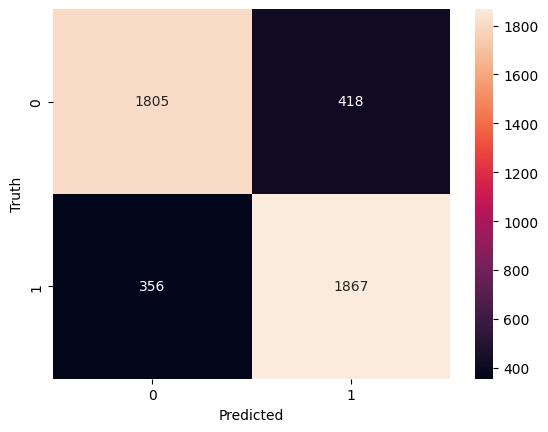

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

First Model: "Custom"

Second Model: "RoBERTa"

In [ ]:
# @title
tweets = [
    'She was struggling with depression, and her thoughts turned to suicide',
    'I am suffering from post-traumatic-stress-disorder',
    'I enjoyed swimming in the pool',
    'I read newspaper today',
    'I love travelling',
    'I am riding bicycle',
    'I am suffering from depression'
]

z=model.predict(tweets)
print("\033[93m{}\033[00m" .format("Predicted results:"))
print("\n")

for score, tweet in zip(z, tweets):
    if score > 0.5:
        print(f"\033[91m{tweet}\nSuicidal thought: {score}\033[0mf")
    else:
        print(f"\033[92m{tweet}\nNon-suicide detected: {score}\033[0m")

#endof1
print("\n")

roberta = "cardiffnlp/twitter-roberta-base-sentiment"
model2 = AutoModelForSequenceClassification.from_pretrained(roberta)
tokenizer = AutoTokenizer.from_pretrained(roberta)

labels = ['Negative 😞', 'Neutral 😐', 'Positive 😀']

for i, tweet in enumerate(tweets, start=1):
    # Preprocess tweet
    tweet_words = []

    for word in tweet.split(' '):
        if word.startswith('@') and len(word) > 1:
            word = '@user'
        elif word.startswith('http'):
            word = "http"
        tweet_words.append(word)

    tweet_proc = " ".join(tweet_words)

    # Sentiment analysis
    encoded_tweet = tokenizer(tweet_proc, return_tensors='pt')
    output = model2(**encoded_tweet)

    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    print(f"Tweet{i}:'{tweet}'")
    print("\033[93m{}\033[00m" .format("Sentiment Scores:"))

    for label, score in zip(labels, scores):
        print(f"{label}: {score:.5f}")
    print("\n")

1/1 [==============================] - 4s 4s/step
Predicted results:


She was struggling with depression, and her thoughts turned to suicide
Suicidal thought: [0.59830844]f
I am suffering from post-traumatic-stress-disorder
Suicidal thought: [0.5286192]f
I enjoyed swimming in the pool
Non-suicide detected: [0.21068294]
I read newspaper today
Non-suicide detected: [0.10882136]
I love travelling
Non-suicide detected: [0.08103864]
I am riding bicycle
Non-suicide detected: [0.15991238]
I am suffering from depression
Non-suicide detected: [0.44938448]


Tweet1:'She was struggling with depression, and her thoughts turned to suicide'
Sentiment Scores:
Negative 😞: 0.90448
Neutral 😐: 0.09167
Positive 😀: 0.00385


Tweet2:'I am suffering from post-traumatic-stress-disorder'
Sentiment Scores:
Negative 😞: 0.96844
Neutral 😐: 0.02909
Positive 😀: 0.00248


Tweet3:'I enjoyed swimming in the pool'
Sentiment Scores:
Negative 😞: 0.00201
Neutral 😐: 0.03090
Positive 😀: 0.96709


Tweet4:'I read newspaper to

**PIE CHART SHOWING DISTRIBUTION OF SUICIDAL VS NON- SUICIDAL THOUGHTS**

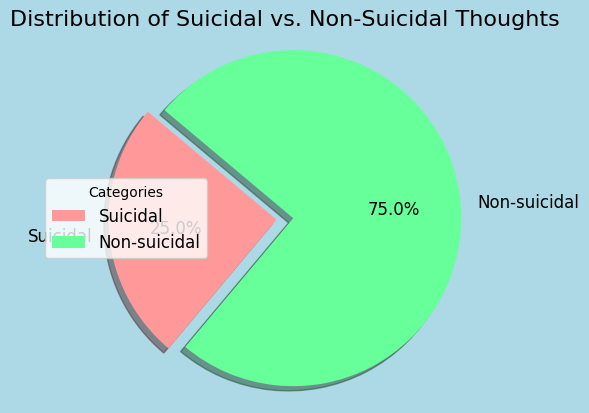

In [ ]:
# @title
suicidal_counts = 0
non_suicidal_counts = 0

for score in z:
    if score > 0.5:
        suicidal_counts += 1
    else:
        non_suicidal_counts += 1

# Data to plot
labels = 'Suicidal', 'Non-suicidal'
sizes = [suicidal_counts, non_suicidal_counts]
colors = ['#ff9999', '#66ff99']  # Green for Non-suicidal and orange for Suicidal
explode = (0.1, 0)  # Explode the 'Suicidal' slice for emphasis

# Plot
fig, ax = plt.subplots()
ax.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
       shadow=True, startangle=140, textprops={'fontsize': 12})  # Adjust text font size

ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Suicidal vs. Non-Suicidal Thoughts', fontsize=16)

# Add a legend
plt.legend(labels, loc="best", title="Categories", fontsize=12)

# Set background color to orange
fig.patch.set_facecolor('#ADD8E6')  # Orange background

# Show the pie chart
plt.show()

**BAR CHART FOR SENTIMENT SCORES**

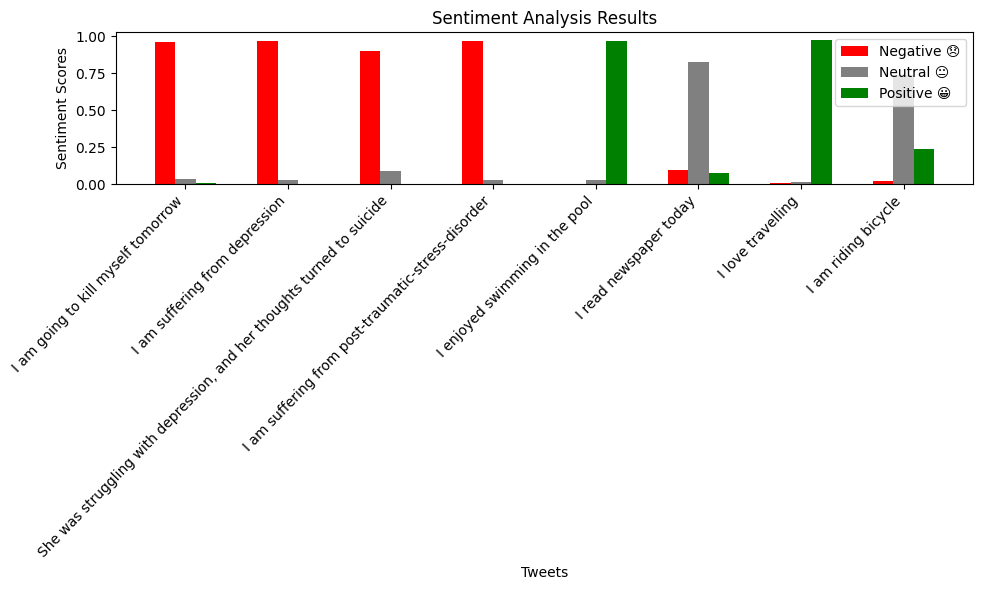

In [ ]:
# @title
# Lists to store sentiment scores
negative_scores = []
neutral_scores = []
positive_scores = []

# Sentiment analysis and storing scores
for tweet in tweets:
    tweet_words = []

    for word in tweet.split(' '):
        if word.startswith('@') and len(word) > 1:
            word = '@user'
        elif word.startswith('http'):
            word = "http"
        tweet_words.append(word)

    tweet_proc = " ".join(tweet_words)

    encoded_tweet = tokenizer(tweet_proc, return_tensors='pt')
    output = model2(**encoded_tweet)

    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    negative_scores.append(scores[0])
    neutral_scores.append(scores[1])
    positive_scores.append(scores[2])

# Create a bar chart for sentiment scores
plt.figure(figsize=(10, 6))
x = range(len(tweets))

# Specify custom colors: Red for negative and Gray for neutral
colors = ['red', 'gray', 'green']
bar_width = 0.2

plt.bar(x, negative_scores, width=bar_width, label='Negative 😞', color=colors[0])
plt.bar([i + bar_width for i in x], neutral_scores, width=bar_width, label='Neutral 😐', color=colors[1])
plt.bar([i + 2 * bar_width for i in x], positive_scores, width=bar_width, label='Positive 😀', color=colors[2])

plt.xlabel('Tweets')
plt.ylabel('Sentiment Scores')
plt.title('Sentiment Analysis Results')
plt.xticks([i + bar_width for i in x], tweets, rotation=46, ha="right")
plt.legend()
plt.tight_layout()

# Show the bar chart
plt.show()